In [12]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping



### Import Data

In [13]:
import pandas as pd

luco_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Aquifer_Luco.csv')
luco_df.head()

,Date,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,...,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
0,01/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,5.50,0.80,NaN,NaN,NaN
1,02/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,6.20,3.25,NaN,NaN,NaN
2,03/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.25,0.95,NaN,NaN,NaN
3,04/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.00,4.20,NaN,NaN,NaN
4,05/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.90,6.55,NaN,NaN,NaN


In [14]:
luco_df.isnull().sum()
luco_df = luco_df.dropna()
print(luco_df)

            Date  Rainfall_Simignano  Rainfall_Siena_Poggio_al_Vento  \
6536  23/11/2017                 0.0                             0.0   
6537  24/11/2017                 0.2                             0.0   
6538  25/11/2017                 0.0                             0.0   
6539  26/11/2017                 0.0                             0.0   
6540  27/11/2017                 0.2                             0.6   
...          ...                 ...                             ...   
6935  27/12/2018                 0.0                             0.0   
6936  28/12/2018                 0.2                             0.0   
6937  29/12/2018                 0.0                             0.0   
6938  30/12/2018                 0.0                             0.2   
6939  31/12/2018                 0.0                             0.0   

      Rainfall_Mensano  Rainfall_Montalcinello  Rainfall_Monticiano_la_Pineta  \
6536               0.0                     0.0        

### Format Time Series Date Field

In [15]:
from datetime import datetime

original_date = luco_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
luco_df['formatted_date'] = pd.to_datetime(luco_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(luco_df['formatted_date'])


6536    11/23/2017
6537    11/24/2017
6538    11/25/2017
6539    11/26/2017
6540    11/27/2017
           ...    
6935    12/27/2018
6936    12/28/2018
6937    12/29/2018
6938    12/30/2018
6939    12/31/2018
Name: formatted_date, Length: 363, dtype: object


In [16]:
luco_df = luco_df.set_index('formatted_date')
luco_df = luco_df.drop(columns=['Date'])
luco_df.head()

,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,Rainfall_Monteroni_Arbia_Biena,...,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
formatted_date,,,,,,,,,,,,,,,,,,,,,
11/23/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,...,-10.1,-9.0,-12.2,12.30,11.40,11.15,11.30,-222.906240,-136.90560,-227.968320
11/24/2017,0.2,0.0,0.2,0.4,0.2,0.2,0.2,0.0,0.2,0.2,...,-10.5,-8.4,-12.0,12.20,11.20,11.90,10.65,-222.906240,-136.90560,-227.968320
11/25/2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,-10.2,-9.8,-12.1,12.55,13.05,12.40,13.00,-222.906240,-136.90560,-227.968320
11/26/2017,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.2,0.0,0.0,...,-10.2,-9.1,-12.1,7.75,6.85,7.05,7.10,-211.760928,-130.06032,-216.569904
11/27/2017,0.2,0.6,0.0,0.0,0.2,0.0,0.2,0.6,0.0,0.0,...,-10.3,-8.8,-12.2,6.15,4.90,4.25,3.60,-222.906240,-136.90560,-227.968320


In [17]:
luco_df.columns

Index(['Rainfall_Simignano', 'Rainfall_Siena_Poggio_al_Vento',
       'Rainfall_Mensano', 'Rainfall_Montalcinello',
       'Rainfall_Monticiano_la_Pineta', 'Rainfall_Sovicille',
       'Rainfall_Ponte_Orgia', 'Rainfall_Scorgiano', 'Rainfall_Pentolina',
       'Rainfall_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta',
       'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_3',
       'Depth_to_Groundwater_Pozzo_4', 'Temperature_Siena_Poggio_al_Vento',
       'Temperature_Mensano', 'Temperature_Pentolina',
       'Temperature_Monteroni_Arbia_Biena', 'Volume_Pozzo_1', 'Volume_Pozzo_3',
       'Volume_Pozzo_4'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [18]:
target_columns = ['Depth_to_Groundwater_Podere_Casetta']
feature_columns = luco_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [19]:
# Ensure X is defined

def prepare_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_feature_data(luco_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("luco_df shape:", luco_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 266, Test size: 67


### LSTM Model Multi-Target

In [21]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Define Early Stopping to precvent Overfitting 

In [22]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)



In [24]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (266, 30, 20)
y_train shape: (266, 1)
Epoch 1/100


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.1501 - val_loss: 0.0228
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0427 - val_loss: 0.0345
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0212 - val_loss: 0.0290
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0151 - val_loss: 0.0091
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0063 - val_loss: 0.0073
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0051 - val_loss: 

### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [25]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.5214499 ]
 [0.50384384]
 [0.47939333]
 [0.45744523]
 [0.4932122 ]
 [0.50821704]
 [0.49731565]
 [0.51836   ]
 [0.550164  ]
 [0.55947167]
 [0.568202  ]
 [0.5736322 ]
 [0.5723173 ]
 [0.5794065 ]
 [0.5727648 ]
 [0.5652709 ]
 [0.5612656 ]
 [0.5501705 ]
 [0.543576  ]
 [0.5321791 ]
 [0.5207481 ]
 [0.5036791 ]
 [0.48197758]
 [0.4516561 ]
 [0.4253059 ]
 [0.396443  ]
 [0.38530678]
 [0.37929145]
 [0.3684845 ]
 [0.36277044]
 [0.35975266]
 [0.36132723]
 [0.35539067]
 [0.33510238]
 [0.25749993]
 [0.20672756]
 [0.17949437]
 [0.14626   ]
 [0.12064432]
 [0.1146622 ]
 [0.11722566]
 [0.11231074]
 [0.09844008]
 [0.1060396 ]
 [0.10978249]
 [0.10435602]
 [0.09861765]
 [0.08774078]
 [0.07489193]
 [0.06561495]
 [0.05597904]
 [0.04779617]
 [0.0398993 ]
 [0.05000295]
 [0.04873626]
 [0.04637072]
 [0.04712188]
 [0.04492708]
 [0.04554808]
 [0.04584149]
 [0.04539687]
 [0.04110407]
 [0.03881145]
 [0.0378003 ]
 [0.03768798]
 [0.03701916]

### Convert back to normal scale

In [26]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

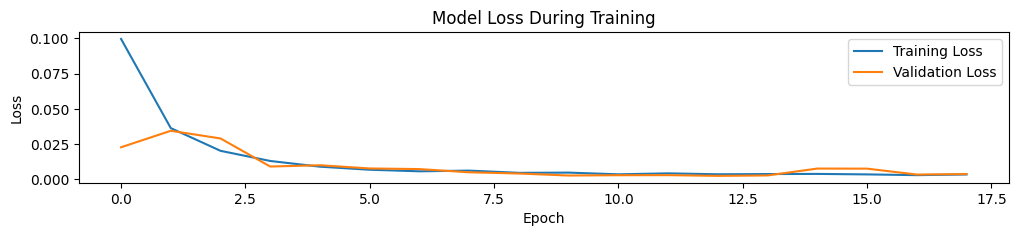

In [27]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [28]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [37]:
evaluate_regression_lstm(y_test_orig, test_pred)


Regression Metrics:
R² Score: -138.3339
MAE: 0.4604
RMSE: 0.5136


(-138.333850793393, 0.4603605213449971, 0.5136448997458714)

## Plot Residuals - Actual vs Predicted

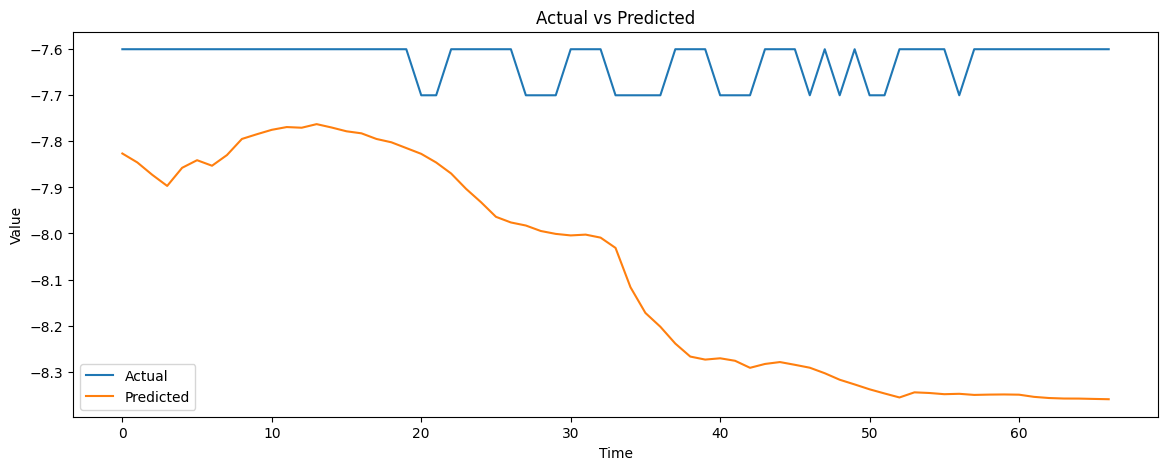

In [38]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig, test_pred)


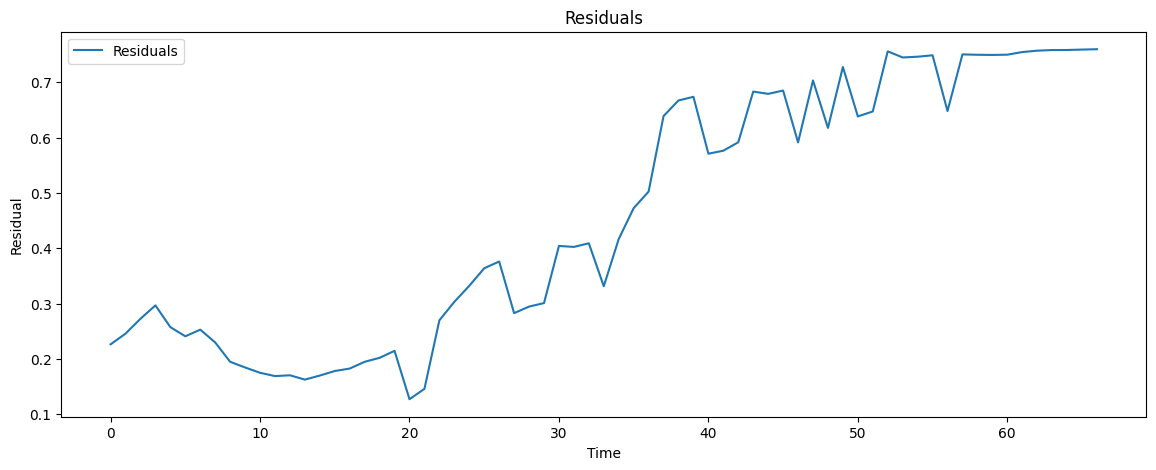

: 

In [39]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')

## Find Optimal Learning Rate 

### Find Optimal Learning Rate 

In [35]:
def find_optimal_lr(model, X_train, y_train):
    lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
    losses = []
    
    for lr in lr_schedule:
        model.optimizer.learning_rate.assign(lr)
        loss = model.train_on_batch(X_train[:32], y_train[:32])
        losses.append(loss)
        
    best_lr = lr_schedule[np.argmin(losses)]
    return best_lr

find_optimal_lr(model, X_train, y_train)

KeyboardInterrupt: 